# Part 1 - Data Preparation and Preprocessing [8 Points]


In [227]:
# IMPORT MODULES
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
# returns the first number in the range so it can be sorted by that value
def RangeCompare(x):
    return int(x.split()[0])

# Custom sort function for the salary ranges
def RangeSort(df_indexes):
    return sorted(df_indexes, key = RangeCompare)

In [228]:
# Perform data preparation and processing
## code
orig_df = pd.read_csv("data.csv")

In [229]:
# drop id, drop duplicates
orig_df = orig_df.drop_duplicates()
orig_df = orig_df.drop(columns='Id')

In [230]:
# take job type from title put in job type column where job type is NaN
jTypes = ['Casual', 'Part Time', 'Full Time']
edited = 0

for index, row in orig_df.iterrows():
    for job in jTypes:
        match = re.match(job, row['Title'], re.IGNORECASE)
        
        if match is not None:
            # Replace the job type from the title
            orig_df.at[index, 'Title'] = row['Title'].replace(match.group(), '')
            
            # If the row has no job type add it in
            if pd.isnull(row['JobType']):
                if job == 'Casual':
                    orig_df.at[index, 'JobType'] = 'Casual/Vacation'
                else:
                    orig_df.at[index, 'JobType'] = job
            edited += 1
print('Number of Job Types Edited: ', edited)
orig_df[['Title', 'JobType']].head()

Number of Job Types Edited:  13670


,Title,JobType
0,Stock Replenisher,Casual/Vacation
1,Stock Replenisher,Casual/Vacation
2,RETAIL SALES SUPERSTARS and STYLISTS Wanted - ...,NaN
3,Team member - Belrose,NaN
4,"Business Banking Contact Centre Specialist, Ni...",NaN


In [231]:
# create separate data frames
job_type_df = orig_df[['SubClassification', 'JobType']].copy()
job_type_df = job_type_df.dropna(axis=0, subset=['JobType'])
class_subclass_df = orig_df[['Location', 'Classification', 'SubClassification']].copy()
class_subclass_df.dropna()
# can talk about how actual salary and full description different
salary_df = orig_df[['Location','SubClassification', 'Classification', 'LowestSalary', 'HighestSalary']].copy()
loc_most_paid_df = salary_df.copy().drop(columns=['Classification','SubClassification'])

### 1) Describe the dataset


Most of the data is either categorical or textual data (title, company, location, area, classification, subclassification, requirements, full description and job type) with the only real numerical data being the date of posting and the lowest / highest salaries. From looking at the data it is clear that except for id, title, date and lowest / highest salary all other columns have some number of missing data entries. Therefore, when analysing particular columns, we will drop the relevant missing data rows.

The main attributes of the marketing data set that is going to be used is the dates, location, classification and subclassification, lowest / highest salary and job type. For some of the job postings the job type is present in the title but not in the ‘JobType’ column therefore some cleaning will need to be done. It should also be noted that for some jobs the salary range and their ‘FullDescription’ job salary differs. Due to the fact that it is quite difficult to parse the full descriptions of each posting to obtain the appropriate range (e.g. salary being stated in different ways 90K, $400 000, thirty thousand a  year etc. & superannuation sometimes being included) and the fact that it does not occur too often it will be omitted from cleaning.

### 2) Describe the steps you used for data preparation and preprocessing

[2-3 Paragraphs] 
#### 2.1. How did we load the data?
#### 2.2. How did we normalize the data?
#### 2.3. How did we clean the data?
- Can talk about initial insights about $ salary differences in data and job type inconsistences

### 3) What is your hypothesis about the analysis outcome?

[1-2 paragraphs] This our hypothesis

# Part 2 - Data Analysis and Interpretation [17 points]

- Perform exploratory data analysis
- Perform statistical data analysis
- Perform predictive data analysis

In [232]:
## CODE
## Perform predictive on where the job market will be in x years

### 1) Study the job metadata. Extract the relevant information to describe the job's attributes.

#### 1.1 What are the ranges of salaries for sub classification? 

In [233]:
salary_df['SalaryRange'] = '0' 
for index, row in salary_df.iterrows():
    salary_df.at[index, 'SalaryRange'] = str(row['LowestSalary']) + \
                                            ' - ' + str(row['HighestSalary'])
    
salary_df = salary_df.drop(columns=['LowestSalary', 'HighestSalary'])
salary_df.head()
salary_location_df = salary_df.copy()
salary_df = salary_df.drop(columns=['Location'])

,SubClassification,Classification,SalaryRange
0,Retail Assistants,Retail & Consumer Products,0 - 30
1,Retail Assistants,Retail & Consumer Products,0 - 30
2,Retail Assistants,Retail & Consumer Products,0 - 30
3,Retail Assistants,Retail & Consumer Products,0 - 30
4,Sales - Inbound,Call Centre & Customer Service,0 - 30


In [234]:
# Grouping the salary data frame by subclass and salary range to produce the table
salary_count_df = salary_df.groupby(['SubClassification', 'SalaryRange']).count(
                    ).rename(columns = {'Classification' : 'Number of Jobs'})

salary_count_df.sort_values(by=['SubClassification', 'Number of Jobs'], 
                            ascending=[True, False],  inplace=True)

salary_count_df.head()

Number of Jobs
SubClassification                 SalaryRange                
Account & Relationship Management 0 - 30                  409
                                  100 - 120               241
                                  70 - 80                 230
                                  80 - 100                227
                                  60 - 70                 215

In [235]:
# Access a particular sub classes range information. If n given, top n ranges returned based on counts
def SalaryData(sc_df, subclass, n = 0):
    if n == 0:
        return sc_df.loc[subclass, :]
    else:
        return sc_df.loc[subclass, :].nlargest(n, 'Number of Jobs')

print('Sub Classification: CEO \n')
print(SalaryData(salary_count_df, 'CEO'))

Sub Classification: CEO 

             Number of Jobs
SalaryRange                
200 - 999                64
150 - 200                52
0 - 30                   18
120 - 150                10
100 - 120                 7
80 - 100                  5
70 - 80                   3
30 - 40                   2
60 - 70                   2


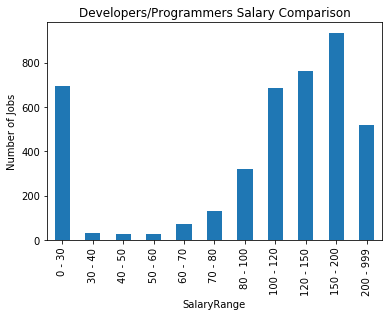

In [236]:
# Plot Developers/Programmers Data by calling the SalaryData function
temp_df = SalaryData(salary_count_df, 'Developers/Programmers').sort_values(by=['SalaryRange'])
temp_df = temp_df.reindex(index=RangeSort(temp_df.index))

ax = temp_df.plot.bar(title='Developers/Programmers Salary Comparison', legend=False)
ax.set_ylabel('Number of Jobs')
ax

#### 1.1.1 Discussion
From looking at the raw data, there are examples of jobs that have conflicting salaries. Their full descriptions and the lowest and highest salaries differ and with the fact that all jobs have a lowest and highest salary it is clear that the range 0 - 30 is a default value that some job postings haven't changed. This can be clearly seen by looking at the data for the 'CEO' sub classification (Table TBA), it isn't realistic for so many jobs to be in the 0 - 30 range for such a demanding job. 

The ‘salary_count_df’ Data Frame allows us to generate histograms like the one for Developers/Programmers (Graph TBA) showing the distribution of job postings by salary range. A function (called ‘SalaryData’) was created to obtain easy access to the salary range data for every sub classification that exists. The function takes ‘salary_count_df’, a sub class name and number of ranges to be returned in order of posting numbers. If the function is passed nothing it returns all the ranges to the function. 


#### 1.2 Where is the location of the sub class?

In [237]:
# Create DF containing counts of the jobs in each city grouped by their classification
loc_class_count_df = class_subclass_df.groupby(['Location', 'Classification']).count(
                        ).rename(columns = {'SubClassification' : 'Number of Jobs'})

loc_class_count_df.head()

Number of Jobs
Location Classification                                 
ACT      Accounting                                  180
         Administration & Office Support             319
         Advertising, Arts & Media                    22
         Banking & Financial Services                 47
         CEO & General Management                     22

In [238]:
# Access a particular cities job information, if n given top n jobs returned based on counts
def CityData(lc_df, city, n = 0):
    if n == 0:
        return lc_df.loc[city, :]
    else:
        return lc_df.loc[city, :].nlargest(n, 'Number of Jobs')


lc_df = CityData(loc_class_count_df, 'Melbourne', 5)

print('City: Melbourne \n')
print(lc_df.head())

City: Melbourne 

                                        Number of Jobs
Classification                                        
Information & Communication Technology            5889
Hospitality & Tourism                             4060
Trades & Services                                 3831
Manufacturing, Transport & Logistics              3556
Healthcare & Medical                              3493


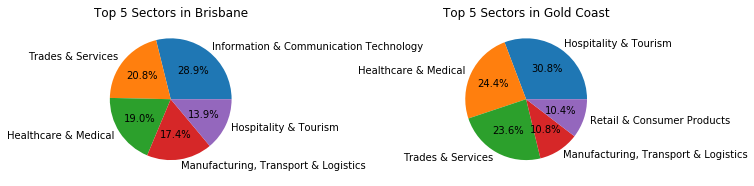

In [239]:
# Graphing a comparison between the top 5 sectors for Gold Coast and Brisbane 
fig1, ax = plt.subplots(1, 2)

lc_df = CityData(loc_class_count_df, 'Brisbane', 5)
ax[0].pie(lc_df['Number of Jobs'], labels=lc_df.index, autopct='%1.1f%%')
ax[0].set_title('Top 5 Sectors in Brisbane')

lc_df2 = CityData(loc_class_count_df, 'Gold Coast', 5)
ax[1].pie(lc_df2['Number of Jobs'], labels=lc_df2.index, autopct='%1.1f%%')
ax[1].set_title('Top 5 Sectors in Gold Coast')

box = ax[1].get_position()
box.x0 = box.x0 + 0.4
box.x1 = box.x1 + 0.4
ax[1].set_position(box)


plt.show()

#### 1.2.1 Discussion
The ‘loc_class_count_df’ is a data frame grouped by the location and classification, for each classification is shows the number of job postings at that location. The function ‘CityData()’ can access an individual cities classification posting information. It takes the ‘loc_class_count_df’, city name and number of classifications to return ordered by job postings as parameters. As hypothesised the most common jobs in the Gold Coast were in the Hospitality & tourism sector and in the same vein Brisbane has a lot of Information & Communication Technology job postings (Graph TBA). The data also revealed that Melbourne (Table TBA), Brisbane and the Gold Coast had four sectors in common (Trades & Services, Hospitality & Tourism, Manufacturing, Transport & Logistics, and Healthcare & Medical).


### 2) Study the job market by locations

#### 2.1 What is the market size in each city? Which are the hottest job sectors in each city?



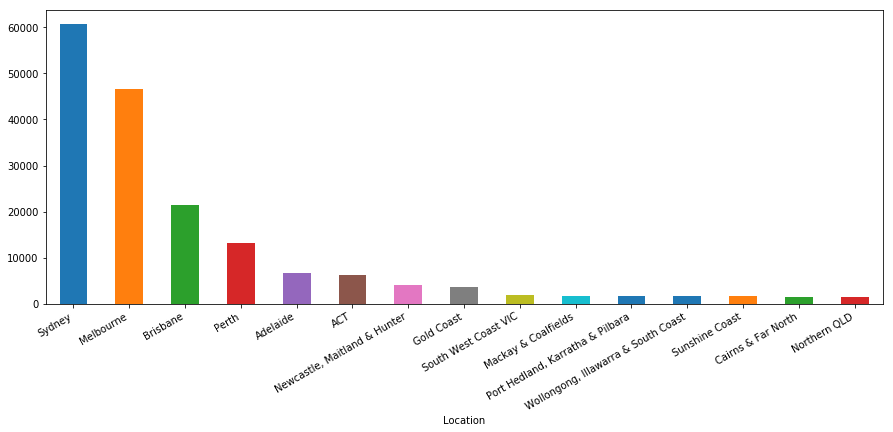

In [240]:
market_size = pd.DataFrame()
market_size['Number of Jobs'] = class_subclass_df.groupby('Location')['Classification'].count()
market_size.head()
f, ax = plt.subplots(figsize=(15, 6))
market_size['Number of Jobs'].sort_values(ascending=False).head(15).plot(kind='bar')
f.autofmt_xdate()
plt.show()

In [241]:
pd.get_option("display.max_rows")
hottest_job_sec = pd.DataFrame()
lowest_job_sec = pd.DataFrame()
lowest_job_sec['Classification'] = class_subclass_df.groupby('Location')['Classification'].min()
lowest_job_sec['SubClassification'] = class_subclass_df.groupby('Location')['SubClassification'].min()
hottest_job_sec['# of Jobs'] = class_subclass_df.groupby(['Location', 'Classification'])['Location'].count()
new_df = pd.DataFrame()
max_val = 0
index = 0
cities = []
classifications = []
max_sector = []
for i in hottest_job_sec.index:
    num = hottest_job_sec['# of Jobs'][i]
    if num > max_val:
        max_val = num
        city = i[0]
        class_type = i[1]
    if i[0] != city:
        cities.insert(index, city)
        classifications.insert(index, class_type)
        max_sector.insert(index, max_val)
        index += 1
        max_val = 0
        
new_df.head()
new_df['Location']  = cities
new_df['Classification'] = classifications
new_df['#'] = max_sector
new_df.head(10)

,Location,Classification,#
0,ACT,Information & Communication Technology,2057
1,Adelaide,Trades & Services,819
2,Adelaide Hills & Barossa,Hospitality & Tourism,33
3,Albany & Great Southern,Healthcare & Medical,24
4,Albury Area,Healthcare & Medical,89
5,Alice Springs & Central Australia,Healthcare & Medical,59
6,Bairnsdale & Gippsland,Education & Training,71
7,Ballarat & Central Highlands,Healthcare & Medical,111
8,"Bendigo, Goldfields & Macedon Ranges",Healthcare & Medical,146
9,Brisbane,Information & Communication Technology,2768


#### 2.2 Which range of salary is common on each city? Where are the employees more well-paid?

In [242]:
salary_location_df = salary_location_df.drop(columns=['SubClassification', 'Classification'])

In [243]:
salary_range_count = pd.DataFrame()
salary_range_count['#'] = salary_location_df.groupby(['Location', 'SalaryRange'])['SalaryRange'].count()
salary_loc_count = pd.DataFrame()
salary_range = []
common_range = []
locations = []
def get_most_common(df, df_col, ls1, ls2, ls3):
    max_val = 0
    index = 0
    for i in df.index:
        num = df[df_col][i]
        if num > max_val:
            max_val = num
            city = i[0]
            sal_range = i[1]
        if i[0] != city:
            ls1.insert(index, sal_range)
            ls2.insert(index, max_val)
            ls3.insert(index, city)
            index += 1
            max_val = 0
get_most_common(salary_range_count, '#', salary_range, common_range, locations)        
salary_loc_count['Location'] = locations
salary_loc_count['SalaryRange'] = salary_range
salary_loc_count.head(20)

,Location,SalaryRange
0,Adelaide,0 - 30
1,Adelaide Hills & Barossa,40 - 50
2,Albury Area,0 - 30
3,Brisbane,0 - 30
4,Bunbury & South West,0 - 30
5,Cairns & Far North,0 - 30
6,Coffs Harbour & North Coast,0 - 30
7,Darwin,0 - 30
8,Dubbo & Central NSW,0 - 30
9,Far West & North Central NSW,100 - 120


In [244]:
sorted_df = loc_most_paid_df.groupby(['Location', 'LowestSalary', 'HighestSalary'])['HighestSalary'].count()
sorted_df.head(20)

Location  LowestSalary  HighestSalary
ACT       0             30               1071
          30            40                406
          40            50                453
          50            60                315
          60            70                379
          70            80                502
          80            100               391
          100           120               537
          120           150               509
          150           200               976
          200           999               711
Adelaide  0             30               1256
          30            40                619
          40            50               1007
          50            60                718
          60            70                734
          70            80                563
          80            100               445
          100           120               476
          120           150               321
Name: HighestSalary, dtype: int64

#### 2.3 Can you detect the pattern of posting: e.g. are more jobs posted at the beginning of the month?

In [245]:
postings_df = orig_df[['Date']].copy()
postings_df['Date'] = postings_df['Date'].apply(lambda x: x.strip('T00:00:00.000Z'))
pd.to_datetime(postings_df['Date'],format='%Y-%m-%d')
avg_postings_df = postings_df.copy()
postings_df['Day of Month'] = pd.DatetimeIndex(postings_df['Date']).day
postings_df = postings_df.drop(columns=['Date'])
postings_df = postings_df.groupby(['Day of Month'])['Day of Month'].count().reset_index(name='Postings').sort_values(['Postings'], ascending=False)
print(postings_df)

    Day of Month  Postings
0              1     24512
2              3     21804
1              2     18585
10            12     17503
3              4     16728
16            18     16151
8              9     15822
15            17     15539
9             11     15448
4              5     15028
11            13     14793
12            14     14656
18            21     13684
6              7     11309
19            22     10950
27            31     10652
13            15     10132
7              8      9276
17            19      8720
14            16      8332
5              6      6984
26            29      5946
24            27      3557
25            28      3225
23            26      2820
21            24      2542
22            25      2015
20            23      1764


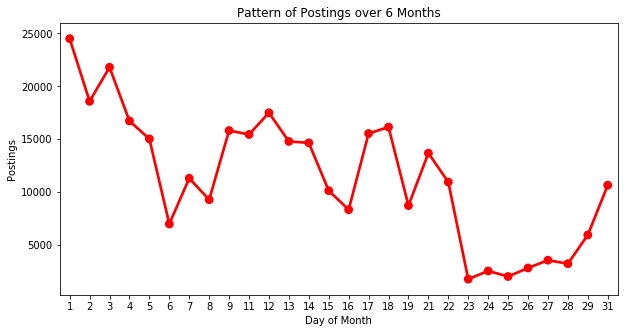

In [246]:
f, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(x='Day of Month', y='Postings', data=postings_df, color='r').set_title('Pattern of Postings over 6 Months')
plt.show()

In [247]:
avg_postings_df['Month'] = pd.DatetimeIndex(avg_postings_df['Date']).month
avg_postings_df['Day'] = pd.DatetimeIndex(avg_postings_df['Date']).day
avg_postings_df = avg_postings_df.groupby(['Month', 'Day'])['Month'].count().groupby(['Day']).mean().reset_index(name='Average Postings').sort_values(['Average Postings'], ascending=False)
avg_postings_df.head()

,Day,Average Postings
0,1,4085.333333
1,2,3717.000000
2,3,3634.000000
27,31,3550.666667
16,18,3230.200000


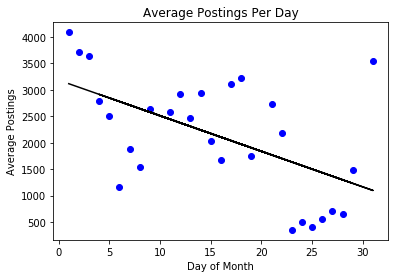

In [248]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score 
# Apply linear regression with the 'postings' feature to predict posting trend
model = LinearRegression()
y = avg_postings_df['Average Postings'].values
X = avg_postings_df[['Day']]

model.fit(X, y)
y_pred = model.predict(X)
posting_score = model.score(X, y)
plt.xlabel('Day of Month')
plt.ylabel('Average Postings')
plt.scatter(X, y, color='b')
plt.title('Average Postings Per Day')
plt.plot(X, y_pred, color='black')

[1-2 paragraphs]
- There are no postings on the 10th, 20th and 30th day of the month
- First three days of the month are the most popular, with the first day being the most frequent

### 3) Study the market by sectors 

#### 3.1 Which sectors keep the highest market share?

#### 3.2 In each sector, which sub-sectors are the main spotlights?

In [249]:
salary_class_df = salary_df.groupby(['Classification', 'SubClassification']).count(
                    ).rename(columns = {'SalaryRange' : 'Count'}).sort_values(['Count'], ascending=False)
salary_class_df.head(10)

,,Count
Classification,SubClassification,
Hospitality & Tourism,Chefs/Cooks,4600
Administration & Office Support,Administrative Assistants,4572
Information & Communication Technology,Developers/Programmers,4211
Retail & Consumer Products,Retail Assistants,3902
Government & Defence,Government - State,3701
"Manufacturing, Transport & Logistics","Warehousing, Storage & Distribution",3636
Sales,Sales Representatives/Consultants,3370
Trades & Services,Automotive Trades,3262
Information & Communication Technology,Business/Systems Analysts,2986


In [250]:
seen_class = set()
spotlight_df = pd.DataFrame(columns=['Classification', 'Spotlight'])

# Loop through the salary_class_df and find the highest sub class for each class
for row in salary_class_df.iterrows():
    classification = row[0][0]
    subclass = row[0][1]
    count = row[1]['Count']
    
    if classification not in seen_class:
        seen_class.add(classification)
        spotlight_df = spotlight_df.append({'Classification': classification, 
                            'Spotlight' : subclass}, ignore_index=True)

spotlight_df.sort_values('Classification')    

,Classification,Spotlight
15,Accounting,Financial Accounting & Reporting
1,Administration & Office Support,Administrative Assistants
28,"Advertising, Arts & Media",Agency Account Management
20,Banking & Financial Services,Compliance & Risk
22,CEO & General Management,General/Business Unit Manager
11,Call Centre & Customer Service,Customer Service - Call Centre
12,Community Services & Development,Aged & Disability Support
13,Construction,Project Management
25,Consulting & Strategy,Management & Change Consulting
23,Design & Architecture,Architecture


#### 3.2.1 Discussion
The data frame ‘salary_class_df’ was created to show the number of job postings for every sub classification along with their respective classification. This makes it easier to find the spotlights for every classification (the sub classifications that have the most job postings). ‘spotlight_df’ contains all the spotlights mentioned in a data frame, it can be used to easily search for the most popular sub classifications. 

#### 3.3 What is the salary range for each sector/sub-sector? Can you compare salary range between sectors/subsectors?

In [251]:
salary_count_df.head()

Number of Jobs
SubClassification                 SalaryRange                
Account & Relationship Management 0 - 30                  409
                                  100 - 120               241
                                  70 - 80                 230
                                  80 - 100                227
                                  60 - 70                 215

In [252]:
avg_salary_df = pd.DataFrame(columns=['Classification', 'SubClassification', 'Avg Salary'])

# Function that returns the classification for a particular sub classification
def GetClass(df, subclass):
    return df[df['SubClassification'] == subclass].Classification.values[0]

range_avg = { '0 - 30' : 15, '30 - 40' : 35, '40 - 50' : 45, '50 - 60' : 55,  '60 - 70' : 65,
    '70 - 80' : 75, '80 - 100' : 90, '100 - 120' : 110, '120 - 150' : 135, '150 - 200' : 175,
    '200 - 999' : 599.5}


current = salary_count_df.index[0][0]
sums = 0
total_jobs = 0

# Loop to create a average salary data frame  
for row in salary_count_df.iterrows():
    subclass = row[0][0]
    # If we have reached a new subclass to sum up calculate the average and append to the data frame
    if subclass != current:
        sums = sums / total_jobs
        avg_salary_df = avg_salary_df.append({'Classification': GetClass(salary_df, current),
                                              'SubClassification': current,
                                             'Avg Salary': sums}, ignore_index=True)
        current = subclass
        sums = 0
        total_jobs = 0
        
    
    rng = row[0][1]
    count = row[1]['Number of Jobs']
    sums += range_avg[rng] * count
    total_jobs += count
    
avg_salary_df.sort_values(by='Avg Salary', ascending=False).head(10)

,Classification,SubClassification,Avg Salary
132,Healthcare & Medical,General Practitioners,412.234759
197,Healthcare & Medical,Medical Specialists,367.311497
50,CEO & General Management,COO & MD,343.392157
49,CEO & General Management,CEO,311.245399
17,Information & Communication Technology,Architects,282.348191
257,Information & Communication Technology,Programme & Project Management,252.101741
133,CEO & General Management,General/Business Unit Manager,248.575000
249,Government & Defence,Police & Corrections,243.220339
68,Accounting,Company Secretaries,225.684211
79,Banking & Financial Services,Corporate Finance & Investment Banking,210.496894


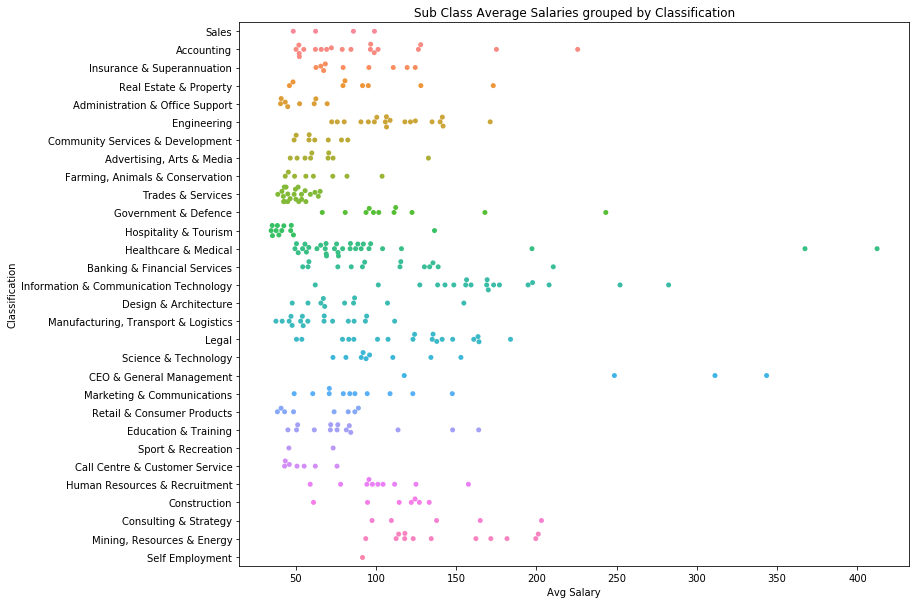

In [253]:
plt.figure(figsize=(12, 10))
ax = sns.swarmplot(x="Avg Salary", y="Classification", data=avg_salary_df)
ax.set_title("Sub Class Average Salaries grouped by Classification")
ax

#### 3.3.1 Discussion
The method of calculating the average salary for each sub classification involves first averaging the salary ranges themselves and then multiplying them by the number of jobs within that particular range. From Table TBA the 0 – 30k range would be averaged to 15k and multiplied by 409 for the ‘Accounting & Relationship Management’ sub class. A dictionary all ‘range_avg’ was created to make access to the average of ranges easier. All the range averages are summed up and then divided by the total number of jobs to give the sub class average salary.

Using the average salary data Graph TBA was created to represent the distribution of salaries for each of the classifications as a swarm plot. The graph allows us to see where the mode salaries lie for every classification. For example, ‘Information and Communication Technology’ jobs hover between the 150k and 200k salary range, there are also some outliers past 250k. It should be noted that the salary range of 200k – 999k skews the data at the high end of the salary averages. Because it has such a big distance between the salary low and high (799k) the average salaries above 200k are not very accurate. For example, the GP average salary isn’t going to be 412k a year (closer to 200k – 300k) but because the average of the range is 599.5k it brings it up.


#### 3.4 What is the trending of market i.e. if a high school student asked you which subject should he/she learn in university (to guarantee a job in the future), what is your advice?

In [254]:
subclass_df = orig_df[['Date','SubClassification']].copy()
top5 = subclass_df.groupby(['SubClassification'])['SubClassification'].count().sort_values(ascending=False).head(6)
subclass_df['Month'] = subclass_df['Date'].apply(lambda x: x.strip('T00:00:00.000Z'))
pd.to_datetime(subclass_df['Month'], format='%Y-%m-%d')
subclass_df['Month'] = pd.DatetimeIndex(subclass_df['Month']).month
#subclass_df = subclass_df.drop(columns=['Date'])
subclass_df = subclass_df.groupby(['SubClassification', 'Month'])['SubClassification'].count().reset_index(name='Postings').sort_values(['Postings'], ascending=False)
print(top5)

SubClassification
Other                        11349
Management                    6236
Chefs/Cooks                   4600
Administrative Assistants     4572
Developers/Programmers        4211
Retail Assistants             3902
Name: SubClassification, dtype: int64


In [255]:
#subclass_df = subclass_df[subclass_df.Month != 3]
ls = ['Management', 'Chefs/Cooks', 'Administrative Assistants',
                                                     'Developers/Programmers', 'Retail Assistants']
subclass_df[subclass_df['SubClassification'].isin(ls)]
management_df = subclass_df[subclass_df['SubClassification'] == 'Management']

[3708, 1329, 1199, 1488.8999999999999]


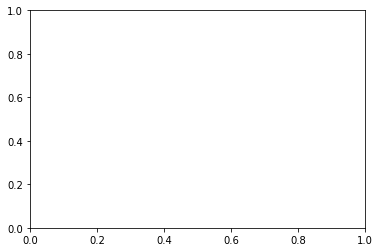

In [256]:
# Using moving average
def movingAvg(data, n):
    pred = data[:]
    for i in range(0, n):
        x_1 = pred[-1] * 0.6
        x_2 = pred[-2] * 0.3
        x_3 = pred[-3] * 0.1
        avg = (x_1 + x_2 + x_3)
        pred.append(avg)
    return pred

f, ax = plt.subplots(1, 1)
mv_avg_df = movingAvg(list(management_df['Postings'].values), 1)
print(mv_avg_df)
#ma_df = moving_average(subclass_df, 4, 6)
#sns.pointplot(x='Month', y='Postings', data=subclass_df, color='b')
#sns.pointplot(x='Month', y='Postings', data=ma_df, color='g')
#ax.legend(handles=ax.lines[::len(subclass_df)+1], labels=["Actual", "3-MA"])
#plt.show()

#### 3.5 Can you detect which skills are required in each sector?

### 4) Visualize the results on an interactive web page
- Trend analysis: visualize number of jobs by locations, by sectors, etc
- Compare between locations or sectors about the number of jobs, the salary, etc.
- Present the necessary skills by sectors, by subsectors

#### 5) Using PySpark for your data analysis [2 points]

# Part 3 - Evaluation [5 Points]

### Part 1) What are the findings of your data analytics?
[2-3 paragraphs, 2 points]

### Part 2) What actions for balancing the markets do you suggest based on your findings?
[1-2 paragraphs, 1 point]

### Part 3) How could you refine your data analytics? [1-2 paragraphs]

#### 3.1 Could you use different data sources?

#### 3.2 Could you choose different parameters?

#### 3.3 Could you choose other techniques?

#### 3.4 Can you think of ways to obtain more relevant data?

### Part 4) Are there any implications for employers and employees based on the findings you obtained? Justify answer. [1-2 paragraphs]
- Answer

#### Part 5) Present and visualize your data story on an online Web Page [OPTIONAL - up to 5 bonus points]
- Publish on Google Cloud or github.io